<i>STATUS: Draft<i>

In [1]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle, Circle, ConnectionPatch
from IPython.display import Image
import sys
import pandas as pd
import HTM_Code as hc
import colorsys
import time as timer

In the last notebook we built a first Spatial Pooler. In this one, we will create another version, but this time we will use the hotgym data. This data set is discussed in both episodes 7 and 8:

In [103]:
ep7 = '<iframe style="background:#99ddff; color:black; padding: 10px" width="400" height="315" src="https://www.youtube.com/embed/R5UoFNtv5AU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
ep8 = '<iframe  style="background:#99ddff; color:black; padding: 10px" width="400" height="315" src="https://www.youtube.com/embed/rHvjykCIrZM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
table = '<table style="width:100%"><tr><td>' + ep7 + '</td><td>' + ep8 + '</td></tr>'
HTML(table)

Its also time now to finally use some real data. Its a data set of 4391 records, that tracks power consuptiom in a gymnasium over time. Let's import the data and have a look at it: 

In [3]:
df = pd.read_csv("./data/gymdata.csv", header=1)
df = df.rename(columns={"datetime": "date_time", "float": "power_consumption"})
df = df.iloc[1:]
df.head()

date_time  power_consumption
1  7/2/10 0:00               21.2
2  7/2/10 1:00               16.4
3  7/2/10 2:00                4.7
4  7/2/10 3:00                4.7
5  7/2/10 4:00                4.6

Let's plot the first 1000 records to get a sense of how things look:

<AxesSubplot:>

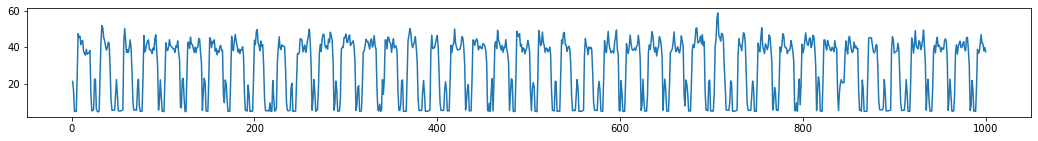

In [4]:
df.power_consumption[:1000].plot(figsize = (18,2))

Next, let's do bit of work on the data set, just to clean up the columns, to seperate date and time, and create an indicator of whether its weekend or not, so the data can easily be placed in a multi-encoder

In [5]:
df.date_time = pd.to_datetime(df.date_time, format="%m/%d/%y %H:%M")
df['date'] = [d.date() for d in df.date_time]
df['time_of_day'] = [d.time() for d in df.date_time]
df['weekday'] = [d.weekday() for d in df.date]
df['is_weekend'] = df.loc[df.weekday < 4, 'weekday'] = 0
df['is_weekend'] = df.loc[df.weekday >= 4, 'weekday'] = 1
df = df.drop('date_time', axis=1)
df = df.drop('weekday', axis=1)

df.head()

power_consumption        date time_of_day  is_weekend
1               21.2  2010-07-02    00:00:00           1
2               16.4  2010-07-02    01:00:00           1
3                4.7  2010-07-02    02:00:00           1
4                4.7  2010-07-02    03:00:00           1
5                4.6  2010-07-02    04:00:00           1

The other thing we will bring in at this point start referencing at this point is a glossary. From episode 7 there is alot of nomencalture with all the HTM stuff, and we need a way to organise it careful with the nomenclature. I want to have it as a handy reference so have just created a spreadhseet, and will now so let's bring that in too and sort it by spatial pooler tag, subtle differences across different things so we need to be start beign really careful with the way we are using language. 

We will also start working more closely with Nupic Code Base at this point

In [6]:
glossary = pd.read_csv("./data/glossary.csv", header=0)
glossary.loc[glossary['Tags'].str.contains("spatial pooler")].style.set_properties(**{'text-align': 'left'})

With that out of the way, let's create an instance of a MultiEncoder and put our data into it. We will need four encoders, one for power consumption, one for date, one for time of day, and one for weekend:

Now let's put all those into a single encoder, the inputs ready for our spatial pooler. 

Now let's create new version of our Spatial Pooler. It will do much of the previous version, but a number of extra features, that get discussed in episode 8. We will also model our Spatial Pooler more along the lines of <a href="#">https://github.com/numenta/nupic/blob/master/src/nupic/algorithms/spatial_pooler.py</a>. We will use similiar variable names, but we will keep the methods a bit simpler to emphasise the various steps in what is happening. The steps will be pretty linear and our code will do the following:

1. <code>intialiseColumnsToInputSpace()</code>
2. <code>addInputsToSpatialPooler()</code>
3. <code>computeOverlapOfInputAndActiveColumn()</code>
4. <code>updateColumnPotentialConnectionsAndReinitialiseColumnToInputSpace()</code>

We will also create a <code>getSummary()</code> function to keep track of things, and <code> create_comparison_from_each_bit_in_input_space_to_its_active_columns()</code> to provide some data so we can look at any given input space and how it is connected:
        

In [265]:
class SpatialPoolerV3:
    def __init__(self,
               inputDimensions=[10, 40],
               columnDimensions=[5, 200],
               potentialRadius=16,
               potentialPct=0.5,
               globalInhibition=True,
               numActiveColumnsPerInhArea=8.0,
               stimulusThreshold=0,
               synPermInactiveDec=0.008,
               synPermActiveInc=0.05,
               synPermConnected=0.10):
        
        self._numInputs = np.prod(inputDimensions)
        self._numColumns = np.prod(columnDimensions)
        self._columnDimensions = columnDimensions
        self._inputDimensions = inputDimensions
        self._potentialRadius = int(max(potentialRadius, self._numInputs))
        self._potentialPct = potentialPct
        self._globalInhibition = globalInhibition 
        self._numActiveColumnsPerInhArea = int(numActiveColumnsPerInhArea)
        self._stimulusThreshold = stimulusThreshold
        self._synPermInactiveDec = synPermInactiveDec
        self._synPermActiveInc = synPermActiveInc
        self._synPermConnected = synPermConnected
        self._columns = {}
        self._columnsInitialised = False
        self._learningIsOn = True
        self._inputs = []
        self.connections_of_bits_in_input_space_to_columns = None
        self.inputs_connected_to_columns = []
    

    def initialiseColumnsToInputSpace(self):
        timerStart = timer.perf_counter()
        potentialPoolSize = int(self._potentialPct * self._numInputs)

        for i in range(self._numColumns):
        
            potentialConnections = hc.create_randomised_sdr(self._numInputs, potentialPoolSize)
            nonConnectedColumns = [x for x in range(0, self._numInputs) if x not in potentialConnections]
            potentialConnectionsPermanenceValues = np.random.normal(self._synPermConnected, 0.01, potentialPoolSize)
            activeColumns = []
            
            for j in range(0, len(potentialConnections)):
                if potentialConnectionsPermanenceValues[j] > 0.1:
                    activeColumns.append(potentialConnections[j])
                    
            self._columns[i] = {'potentialConnections': potentialConnections,
                                'nonConnectedColumns': nonConnectedColumns,
                                'potentialConnectionsPermanenceValues': potentialConnectionsPermanenceValues,
                                'activeColumns': activeColumns
                              }
        self._columnsInitialised = True
        timerEnd = timer.perf_counter()
        self.getSummary(summary_type = 2, timeTaken = timerEnd - timerStart)
    

    
    def compareEachBitInInputSpaceToItsConnectedActiveColumns(self):
        d = []
        for key, value in self._columns.items():
            for i in value['activeColumns']:
                d.append([i, key])
        d.sort()
        e = {}
        f = []
        d.append([-1, -1])
        for j in range(1, len(d) - 1):
            f.append(d[j][1])
            if d[j][0] != d[j + 1][0]:
                e[d[j][0]] = f
                f = []
        self.connections_of_bits_in_input_space_to_columns = e
        
        
    def addInputsToSpatialPooler(self, inputs, multiple = True):
        self._inputs = inputs
    

    def updateColumnPotentialConnectionsAndReinitialiseColumnToInputSpace(self,inputAndAllColumnsOverlaps):


        inputAndAllColumnsOverlaps.sort(key=lambda item: item.get("overlap_score"), reverse = True)
        
        inputAndAllColumnsOverlapsLimitedByActiveColumns = inputAndAllColumnsOverlaps[0:self._numActiveColumnsPerInhArea]
        
        for i in range(len(inputAndAllColumnsOverlapsLimitedByActiveColumns)):
            for j in range(len(inputAndAllColumnsOverlapsLimitedByActiveColumns[i]['overlap_bits'])):
                print("\n##### SUMM")
                print("Column No:", inputAndAllColumnsOverlapsLimitedByActiveColumns[i]['column'])
                colNumber = inputAndAllColumnsOverlapsLimitedByActiveColumns[i]['column']
                overlappedBit = inputAndAllColumnsOverlapsLimitedByActiveColumns[i]['overlap_bits'][j]
                print("Increase permance value at: ", inputAndAllColumnsOverlapsLimitedByActiveColumns[i]['overlap_bits'][j])
                print("COL", self._columns[i])
                try:
                    ind =  self._columns[i]['potentialConnections'].index(overlappedBit)
                except:
                    print("INDEX IS IN NON CONNECTED COLS")
                    ind = self._columns[i]['nonConnectedColumns'].index(overlappedBit)
                    
                    
                print("INDEX OF OVERLAPPED BIT", ind)
                print("INCREASE VALUE: " , self._columns[i]['potentialConnectionsPermanenceValues'][ind])
                self._columns[i]['potentialConnectionsPermanenceValues'][ind] =  self._columns[i]['potentialConnectionsPermanenceValues'][ind] + 100
                print("NEW VAL: ", self._columns[i]['potentialConnectionsPermanenceValues'][ind])
                    
                
    
    def computeOverlapOfInputsAndActiveColumns(self):
        timerStart = timer.perf_counter()
        for i in range(len(self._inputs)):
            inputAndAllColumnsOverlaps = []
            for key, value in self._columns.items():
                overlap = list(set(value['activeColumns']).intersection(self._inputs[i].active_bits))
                inputAndColumnOverlap = {"column": key, "overlap_score": len(overlap), "overlap_bits": overlap}
                inputAndAllColumnsOverlaps.append(inputAndColumnOverlap)
                
            if self._learningIsOn:
                self.updateColumnPotentialConnectionsAndReinitialiseColumnToInputSpace(inputAndAllColumnsOverlaps)
    
        timerEnd = timer.perf_counter()
        self.getSummary(summary_type = 3, timeTaken = timerEnd - timerStart)

    

    
    def getSummary(self, summary_type, timeTaken = 0):
        print("\n----------------- SUMMARY -------------------------")
        if summary_type == 1:
            print("|L1| Column space size (numColumns):", self._numColumns)
            print("|L2| Input space size (numInputs):", self._numInputs)
            print("|L3| Input bits visible to each columns, or receptive field (potentialRadius):", self._potentialRadius)
            print("|L4| The percent of the inputs, within a column's potential radius, that a column can be connected to (potentialPct):", self._potentialPct * 100, "%")
            print("|L5| Global Inhibition is on, meaning winning columns will be selected as the most active columns across the whole region (globalInhibition):", self._globalInhibition)
            print("|L6| Density of active columns within inhibition area (numActiveColumnsPerInhArea):", self._numActiveColumnsPerInhArea)
            print("|L7| Minimum number of synapses that must be on in order for a columns to turn ON (stimulusThreshold):", self._stimulusThreshold)
            print("|L8| Amount by which an inactive synapse is decremented in each time step (synPermInactiveDec):", self._synPermInactiveDec)
            print("|L9| Amount by which an active synapse is incremented in each time step (synPermActiveInc):", self._synPermActiveInc)
            print("|L10| Any synapse whose permanence value is above this value is a connected synapse (synPermConnected):", self._synPermConnected)
            print("|L11| Columns initialised:", self._columnsInitialised)
        elif summary_type == 2:
            print("|L1| Based on initital paramaters, each of the", self._numColumns, "columns in this Spatial Pooler has a potential connection to", self._potentialPct, "of bits in the input space")
            print("|L1| The values of all potential connection strength are normally distributed between approximately", np.round(min(self._columns[0]['potentialConnectionsPermanenceValues']), 3),
              "and", np.round(max(self._columns[0]['potentialConnectionsPermanenceValues']),3))
            print("|L1| Based on the connection threshold set at", self._synPermConnected,",", len(self._columns[0]['activeColumns']), "columns will now be active in the Spatial Pooler")
            print("|L1| Time elapsed during initialisation:", np.round(timeTaken,3), "seconds.")
        elif summary_type == 3:
            print("|L1| Some metric:")
            print("|L1| Time elapsed during initialisation:", np.round(timeTaken,3), "seconds.")

        
s1 = SpatialPoolerV3()
s1.getSummary(1)
s1.initialiseColumnsToInputSpace()
inputSpaceSize = 400
activeBitsInInputs = 20
numberOfInputs = 16
gymPowerConsumptionInputs = [hc.SDR(inputSpaceSize,activeBitsInInputs, "input_" + str(i)) for i in range(0,numberOfInputs)]
s1.addInputsToSpatialPooler(gymPowerConsumptionInputs)
s1.computeOverlapOfInputsAndActiveColumns()
#s1.inputs_connected_to_columns


----------------- SUMMARY -------------------------
|L1| Column space size (numColumns): 1000
|L2| Input space size (numInputs): 400
|L3| Input bits visible to each columns, or receptive field (potentialRadius): 400
|L4| The percent of the inputs, within a column's potential radius, that a column can be connected to (potentialPct): 50.0 %
|L5| Global Inhibition is on, meaning winning columns will be selected as the most active columns across the whole region (globalInhibition): True
|L6| Density of active columns within inhibition area (numActiveColumnsPerInhArea): 8
|L7| Minimum number of synapses that must be on in order for a columns to turn ON (stimulusThreshold): 0
|L8| Amount by which an inactive synapse is decremented in each time step (synPermInactiveDec): 0.008
|L9| Amount by which an active synapse is incremented in each time step (synPermActiveInc): 0.05
|L10| Any synapse whose permanence value is above this value is a connected synapse (synPermConnected): 0.1
|L11| Columns

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



NEW VAL:  200.09325538109567

##### SUMM
Column No: 304
Increase permance value at:  118
COL {'potentialConnections': [1, 3, 5, 8, 9, 10, 13, 14, 16, 18, 20, 22, 24, 26, 28, 29, 31, 32, 33, 34, 37, 38, 39, 42, 44, 46, 49, 51, 53, 55, 56, 57, 59, 63, 67, 68, 72, 76, 78, 79, 84, 86, 88, 89, 93, 94, 95, 96, 99, 101, 102, 105, 107, 108, 109, 110, 112, 113, 115, 118, 121, 122, 124, 126, 127, 128, 131, 132, 133, 140, 142, 143, 145, 146, 148, 149, 151, 152, 155, 156, 158, 162, 164, 168, 170, 172, 174, 177, 179, 181, 185, 188, 189, 195, 200, 202, 203, 204, 205, 207, 210, 212, 213, 218, 221, 222, 225, 227, 230, 233, 236, 237, 241, 242, 245, 246, 250, 251, 252, 254, 255, 256, 260, 261, 262, 263, 264, 266, 267, 268, 269, 270, 272, 273, 275, 276, 277, 281, 286, 287, 290, 293, 294, 295, 296, 300, 301, 302, 303, 305, 306, 307, 310, 311, 313, 316, 318, 319, 323, 324, 327, 329, 334, 335, 336, 340, 341, 342, 346, 349, 350, 351, 354, 356, 357, 358, 364, 368, 369, 370, 371, 375, 376, 378, 379, 381, 382, 

In [235]:
s1._columns[779]['%connect_info'][7]

11

Now let's create our sptial pooler instance, and intitialise the columns to each bit in the input space:

In [167]:
s1 = SpatialPoolerV3()
s1.getSummary(1)
s1.initialiseColumnsToInputSpace()


----------------- SUMMARY -------------------------
|L1| Column space size (numColumns): 1024
|L2| Input space size (numInputs): 16
|L3| Input bits visible to each columns, or receptive field (potentialRadius): 16
|L4| The percent of the inputs, within a column's potential radius, that a column can be connected to (potentialPct): 50.0 %
|L5| Global Inhibition is on, meaning winning columns will be selected as the most active columns across the whole region (globalInhibition): True
|L6| Density of active columns within inhibition area (numActiveColumnsPerInhArea): 10
|L7| Minimum number of synapses that must be on in order for a columns to turn ON (stimulusThreshold): 0
|L8| Amount by which an inactive synapse is decremented in each time step (synPermInactiveDec): 0.008
|L9| Amount by which an active synapse is incremented in each time step (synPermActiveInc): 0.05
|L10| Any synapse whose permanence value is above this value is a connected synapse (synPermConnected): 0.1
|L11| Columns 

We can again compare any bit in the input space to its related active columns:

In [183]:
s1.compareEachBitInInputSpaceToItsConnectedActiveColumns()

In [184]:
randomBitsInInputSpace = np.random.randint(0, 16, 2)
randomBitsInInputSpace 

array([7, 7])

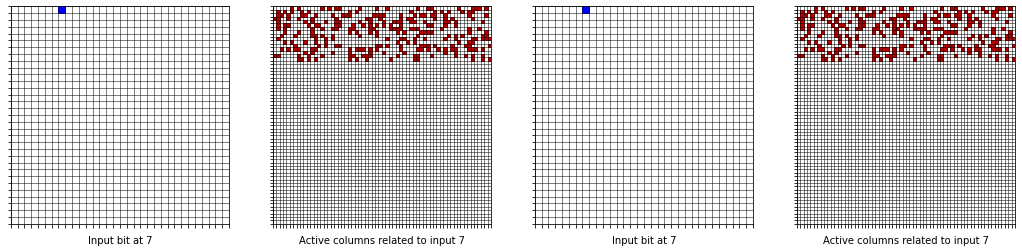

In [185]:
inputSize = 1024
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = hc.create_axis_for_sdr(ax1, np.sqrt(inputSize) + 1, np.sqrt(inputSize) + 1, 
                             20, "Input bit at " + str(randomBitsInInputSpace[0]))
ax2 = hc.create_axis_for_sdr(ax2, np.sqrt(4096) + 1, np.sqrt(4096) + 1, 
                             20, "Active columns related to input " + str(randomBitsInInputSpace[0]))

ax3 = hc.create_axis_for_sdr(ax3, np.sqrt(inputSize) + 1, np.sqrt(inputSize) + 1, 
                             20, "Input bit at " + str(randomBitsInInputSpace[1]))
ax4 = hc.create_axis_for_sdr(ax4, np.sqrt(4096) + 1, np.sqrt(4096) + 1, 
                             20, "Active columns related to input " + str(randomBitsInInputSpace[1]))

coords1 = hc.convert_sdr_to_tuple_for_visualisation([randomBitsInInputSpace[0]], 1024)
coords2 = hc.convert_sdr_to_tuple_for_visualisation(s1.connections_of_bits_in_input_space_to_columns[randomBitsInInputSpace[0]], 4096)
coords3 = hc.convert_sdr_to_tuple_for_visualisation([randomBitsInInputSpace[1]], 1024)
coords4 = hc.convert_sdr_to_tuple_for_visualisation(s1.connections_of_bits_in_input_space_to_columns[randomBitsInInputSpace[1]], 4096)

p = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color = "blue")) for i in range(len(coords1))]
p = [ax2.add_patch(Rectangle(coords2[i], 1, 1, color = "#b30000")) for i in range(len(coords2))]
p = [ax3.add_patch(Rectangle(coords3[i], 1, 1, color = "blue")) for i in range(len(coords3))]
p = [ax4.add_patch(Rectangle(coords4[i], 1, 1, color = "#b30000")) for i in range(len(coords4))]


Next step, place our gym power consumption data in an encoder: 

In [186]:
inputSpaceSize = 10
activeBitsInInputs = 2
gymPowerConsumptionInputs = [hc.SDR(inputSpaceSize,activeBitsInInputs, "input_" + str(i)) for i in range(0,1024)]

So we now have semantically related data points, for each time step in the power consumption data. Let's get a summary of that first SDR

In [ ]:
# create enclder

In [ ]:
gymPowerConsumptionInputs[0].get_summary()

Now add these inputs into our spatial pooler:

In [ ]:
s1.addInputsToSpatialPooler(gymPowerConsumptionInputs)

Now let's compute overlapOf inputs. This time we are going to have learningIsOn set to True

In [187]:
s1.computeOverlapOfInputsAndActiveColumns()


----------------- SUMMARY -------------------------
|L1| Some metric:
|L1| Time elapsed during initialisation: 1.917 seconds.


So what is this telling us, and what metrics should we use to understand it: 



In [ ]:
# now explore metrics, then do c